In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import json
import math
import os
from tensorflow import keras
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
#from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [6]:
normal_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/normal',224))
osteoarthritis_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/osteoarthritis',224))

100%|██████████| 1971/1971 [00:05<00:00, 333.81it/s]


In [7]:
print(len(normal_train))
print(len(osteoarthritis_train))

1020
1971


In [ ]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
osteoarthritis_train_label = np.ones(len(osteoarthritis_train))

In [ ]:
# Merge data
X_train = np.concatenate((normal_train, osteoarthritis_train), axis = 0)
Y_train = np.concatenate((normal_train_label, osteoarthritis_train_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]


In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

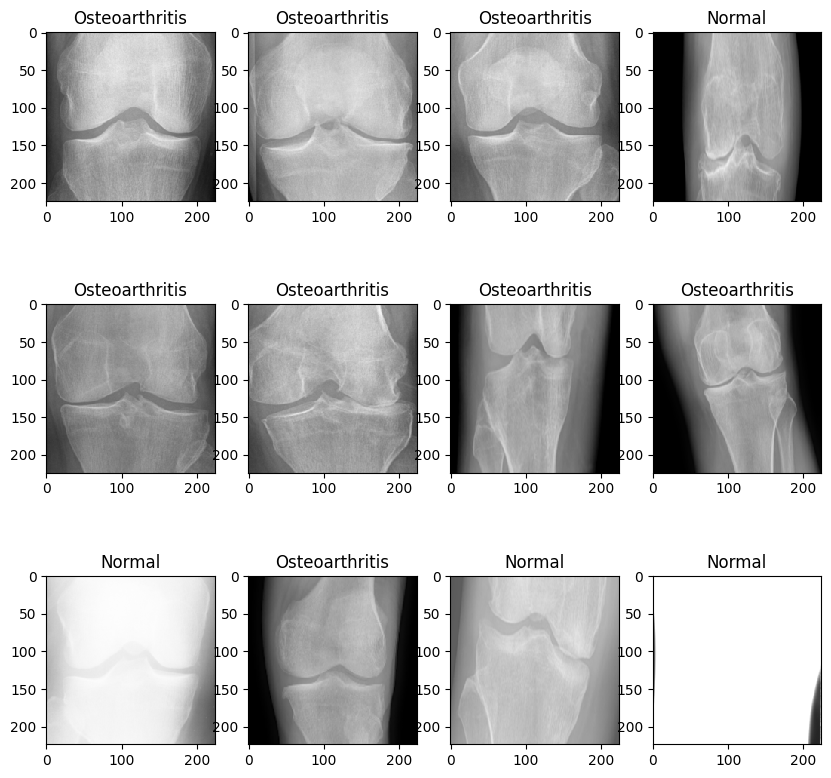

In [ ]:
# # Display first 15 images of moles, and how they are classified
# # Here IDC (+) means Benign
# # IDC (-) means Malignant
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Osteoarthritis')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        # zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

dennet   = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
nas      = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
vgg      = tf.keras.applications.NASNetMobile(include_top=False, input_shape=input_shape)(inputs)

19993432/19993432 [==============================] - 3s 0us/step


In [ ]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(dennet), GlobalAveragePooling2D()(nas)])
# Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(nas)])
# outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(64,activation='relu')(outputs)
# outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 NASNet (Functional)         (None, 7, 7, 1056)           4269716   ['input_1[0][0]']             
                                                                                                  
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)           5433673   ['input_1[0][0]']             
 ional)                                                   6                                       
                                                                                                  
 inception_v3 (Functional)   (None, 5, 5, 2048)           2180278   ['input_1[0][0]']         

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Total params: 80725206 (307.94 MB)
Trainable params: 80584084 (307.40 MB)
Non-trainable params: 141122 (551.26 KB)
__________________________________________________________________________________________________


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-16-9d9ad6683064>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
75/74 [==============================] - ETA: 0s - loss: 0.5690 - accuracy: 0.7433

74/74 [==============================] - 193s 1s/step - loss: 0.5690 - accuracy: 0.7433 - val_loss: 1.0448 - val_accuracy: 0.5058 - lr: 1.0000e-04
Epoch 2/40
75/74 [==============================] - ETA: 0s - loss: 0.4059 - accuracy: 0.8499

74/74 [==============================] - 83s 1s/step - loss: 0.4059 - accuracy: 0.8499 - val_loss: 0.5412 - val_accuracy: 0.8164 - lr: 1.0000e-04
Epoch 3/40
75/74 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.8901

74/74 [==============================] - 87s 1s/step - loss: 0.3176 - accuracy: 0.8901 - val_loss: 0.4855 - val_accuracy: 0.8481 - lr: 1.0000e-04
Epoch 4/40
75/74 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.8984

74/74 [==============================] - 83s 1s/step - loss: 0.2945 - accuracy: 0.8984 - val_loss: 0.3010 - val_accuracy: 0.9366 - lr: 1.0000e-04
Epoch 5/40
75/74 [==============================] - ETA: 0s - loss: 0.2703 - accuracy: 0.9055

74/74 [==============================] - 88s 1s/step - loss: 0.2703 - accuracy: 0.9055 - val_loss: 0.3089 - val_accuracy: 0.9215 - lr: 1.0000e-04
Epoch 6/40
75/74 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9139

74/74 [==============================] - 88s 1s/step - loss: 0.2411 - accuracy: 0.9139 - val_loss: 0.3055 - val_accuracy: 0.9115 - lr: 1.0000e-04
Epoch 7/40
75/74 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9210

74/74 [==============================] - 83s 1s/step - loss: 0.2389 - accuracy: 0.9210 - val_loss: 0.2589 - val_accuracy: 0.9299 - lr: 1.0000e-04
Epoch 8/40
75/74 [==============================] - ETA: 0s - loss: 0.2200 - accuracy: 0.9172

74/74 [==============================] - 88s 1s/step - loss: 0.2200 - accuracy: 0.9172 - val_loss: 0.1886 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 9/40
75/74 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.9093

74/74 [==============================] - 83s 1s/step - loss: 0.2379 - accuracy: 0.9093 - val_loss: 0.2836 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 10/40
75/74 [==============================] - ETA: 0s - loss: 0.2220 - accuracy: 0.9181

74/74 [==============================] - 84s 1s/step - loss: 0.2220 - accuracy: 0.9181 - val_loss: 0.1829 - val_accuracy: 0.9349 - lr: 1.0000e-04
Epoch 11/40
75/74 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9214

74/74 [==============================] - 82s 1s/step - loss: 0.2103 - accuracy: 0.9214 - val_loss: 0.1491 - val_accuracy: 0.9432 - lr: 1.0000e-04
Epoch 12/40
75/74 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.9206

74/74 [==============================] - 89s 1s/step - loss: 0.2090 - accuracy: 0.9206 - val_loss: 1.5991 - val_accuracy: 0.8898 - lr: 1.0000e-04
Epoch 13/40
75/74 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9235

74/74 [==============================] - 88s 1s/step - loss: 0.2145 - accuracy: 0.9235 - val_loss: 0.2315 - val_accuracy: 0.9432 - lr: 1.0000e-04
Epoch 14/40
75/74 [==============================] - ETA: 0s - loss: 0.1874 - accuracy: 0.9394

74/74 [==============================] - 88s 1s/step - loss: 0.1874 - accuracy: 0.9394 - val_loss: 0.2127 - val_accuracy: 0.9332 - lr: 1.0000e-04
Epoch 15/40
75/74 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9369

74/74 [==============================] - 88s 1s/step - loss: 0.1743 - accuracy: 0.9369 - val_loss: 0.3512 - val_accuracy: 0.9149 - lr: 1.0000e-04
Epoch 16/40
75/74 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9461

74/74 [==============================] - 83s 1s/step - loss: 0.1684 - accuracy: 0.9461 - val_loss: 0.1856 - val_accuracy: 0.9249 - lr: 1.0000e-04
Epoch 17/40
75/74 [==============================] - ETA: 0s - loss: 0.1832 - accuracy: 0.9298

74/74 [==============================] - 88s 1s/step - loss: 0.1832 - accuracy: 0.9298 - val_loss: 0.3195 - val_accuracy: 0.9332 - lr: 1.0000e-04
Epoch 18/40
75/74 [==============================] - ETA: 0s - loss: 0.1548 - accuracy: 0.9423

74/74 [==============================] - 88s 1s/step - loss: 0.1548 - accuracy: 0.9423 - val_loss: 0.3375 - val_accuracy: 0.9349 - lr: 1.0000e-04
Epoch 19/40
75/74 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9381

74/74 [==============================] - 89s 1s/step - loss: 0.1734 - accuracy: 0.9381 - val_loss: 0.2197 - val_accuracy: 0.9432 - lr: 1.0000e-04
Epoch 20/40
75/74 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9377

74/74 [==============================] - 88s 1s/step - loss: 0.1681 - accuracy: 0.9377 - val_loss: 0.2453 - val_accuracy: 0.9416 - lr: 1.0000e-04
Epoch 21/40
75/74 [==============================] - ETA: 0s - loss: 0.1535 - accuracy: 0.9423

74/74 [==============================] - 88s 1s/step - loss: 0.1535 - accuracy: 0.9423 - val_loss: 0.2302 - val_accuracy: 0.9432 - lr: 1.0000e-04
Epoch 22/40
75/74 [==============================] - ETA: 0s - loss: 0.1397 - accuracy: 0.9494

74/74 [==============================] - 83s 1s/step - loss: 0.1397 - accuracy: 0.9494 - val_loss: 0.3524 - val_accuracy: 0.9366 - lr: 1.0000e-04
Epoch 23/40
75/74 [==============================] - ETA: 0s - loss: 0.1435 - accuracy: 0.9494

74/74 [==============================] - 88s 1s/step - loss: 0.1435 - accuracy: 0.9494 - val_loss: 0.1623 - val_accuracy: 0.9516 - lr: 1.0000e-04
Epoch 24/40
75/74 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9360

74/74 [==============================] - 88s 1s/step - loss: 0.1712 - accuracy: 0.9360 - val_loss: 0.2423 - val_accuracy: 0.9482 - lr: 1.0000e-04
Epoch 25/40
75/74 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9565

74/74 [==============================] - 88s 1s/step - loss: 0.1212 - accuracy: 0.9565 - val_loss: 0.2328 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 26/40
75/74 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9582

74/74 [==============================] - 88s 1s/step - loss: 0.1285 - accuracy: 0.9582 - val_loss: 0.1665 - val_accuracy: 0.9566 - lr: 1.0000e-04
Epoch 27/40
75/74 [==============================] - ETA: 0s - loss: 0.1487 - accuracy: 0.9448

74/74 [==============================] - 87s 1s/step - loss: 0.1487 - accuracy: 0.9448 - val_loss: 0.1308 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 28/40
75/74 [==============================] - ETA: 0s - loss: 0.1467 - accuracy: 0.9498

74/74 [==============================] - 87s 1s/step - loss: 0.1467 - accuracy: 0.9498 - val_loss: 0.1697 - val_accuracy: 0.9633 - lr: 1.0000e-04
Epoch 29/40
75/74 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.9569

74/74 [==============================] - 87s 1s/step - loss: 0.1301 - accuracy: 0.9569 - val_loss: 0.1874 - val_accuracy: 0.9316 - lr: 1.0000e-04
Epoch 30/40
75/74 [==============================] - ETA: 0s - loss: 0.1359 - accuracy: 0.9511

74/74 [==============================] - 88s 1s/step - loss: 0.1359 - accuracy: 0.9511 - val_loss: 0.2389 - val_accuracy: 0.9466 - lr: 1.0000e-04
Epoch 31/40
75/74 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9511

74/74 [==============================] - 83s 1s/step - loss: 0.1288 - accuracy: 0.9511 - val_loss: 0.2436 - val_accuracy: 0.9549 - lr: 1.0000e-04
Epoch 32/40
75/74 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9578

74/74 [==============================] - 83s 1s/step - loss: 0.1215 - accuracy: 0.9578 - val_loss: 0.2328 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 33/40
75/74 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9536

74/74 [==============================] - 83s 1s/step - loss: 0.1151 - accuracy: 0.9536 - val_loss: 0.2097 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 34/40
75/74 [==============================] - ETA: 0s - loss: 0.1132 - accuracy: 0.9565

74/74 [==============================] - 88s 1s/step - loss: 0.1132 - accuracy: 0.9565 - val_loss: 0.3719 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 35/40
75/74 [==============================] - ETA: 0s - loss: 0.1154 - accuracy: 0.9620

74/74 [==============================] - 88s 1s/step - loss: 0.1154 - accuracy: 0.9620 - val_loss: 0.2803 - val_accuracy: 0.9432 - lr: 1.0000e-04
Epoch 36/40
75/74 [==============================] - ETA: 0s - loss: 0.1328 - accuracy: 0.9523

74/74 [==============================] - 83s 1s/step - loss: 0.1328 - accuracy: 0.9523 - val_loss: 0.9473 - val_accuracy: 0.8948 - lr: 1.0000e-04
Epoch 37/40
75/74 [==============================] - ETA: 0s - loss: 0.1045 - accuracy: 0.9636

74/74 [==============================] - 88s 1s/step - loss: 0.1045 - accuracy: 0.9636 - val_loss: 0.5692 - val_accuracy: 0.9249 - lr: 1.0000e-04
Epoch 38/40
75/74 [==============================] - ETA: 0s - loss: 0.1140 - accuracy: 0.9565

74/74 [==============================] - 88s 1s/step - loss: 0.1140 - accuracy: 0.9565 - val_loss: 0.5438 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 39/40
75/74 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9574

74/74 [==============================] - 88s 1s/step - loss: 0.1213 - accuracy: 0.9574 - val_loss: 0.3216 - val_accuracy: 0.9399 - lr: 1.0000e-04
Epoch 40/40
75/74 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9632

74/74 [==============================] - 88s 1s/step - loss: 0.0968 - accuracy: 0.9632 - val_loss: 0.1816 - val_accuracy: 0.9566 - lr: 1.0000e-04


19/19 [==============================] - 14s 286ms/step
Confusion matrix, without normalization
[[209   4]
 [ 22 364]]


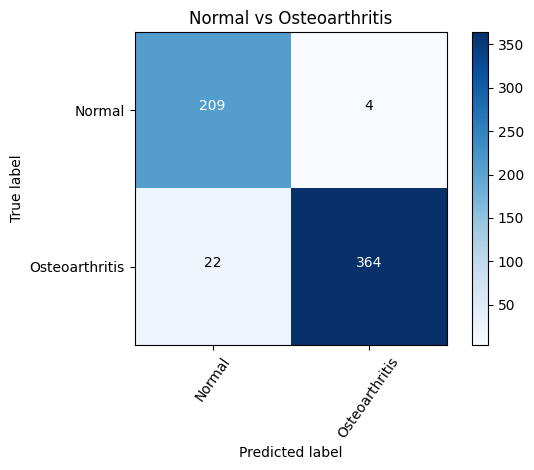

In [ ]:
Y_pred = model.predict(x_val)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Osteoarthritis']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Osteoarthritis')

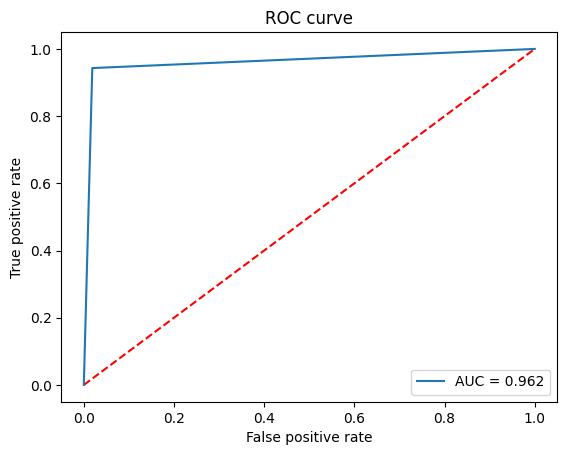

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

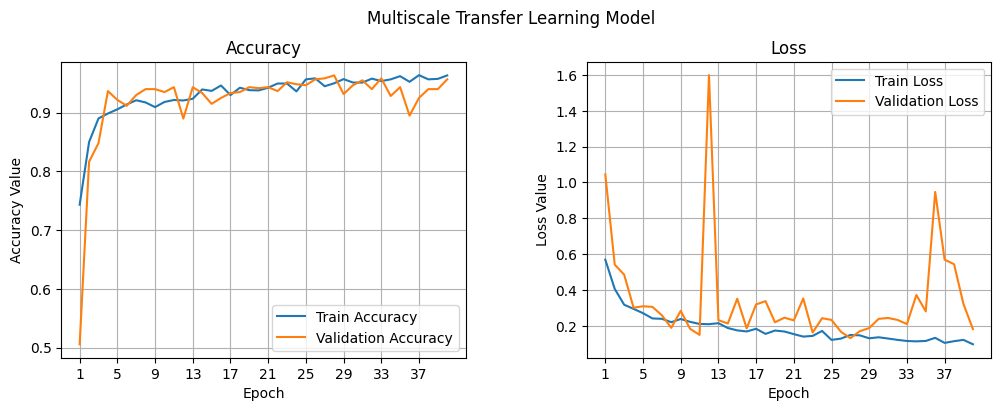

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

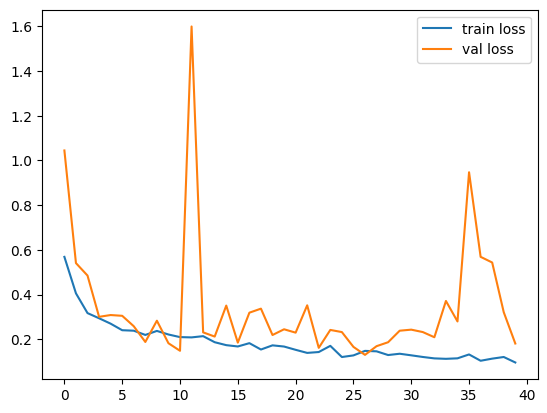

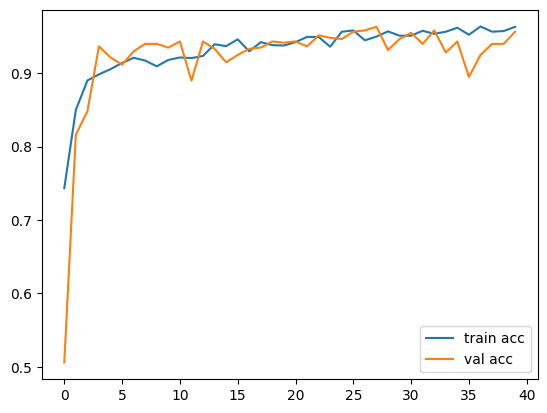

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
pred=model.predict(x_val)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(y_val,1)

19/19 [==============================] - 5s 278ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Osteoarthritis', 'Normal']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
                precision    recall  f1-score   support

Osteoarthritis       0.90      0.98      0.94       213
        Normal       0.99      0.94      0.97       386

      accuracy                           0.96       599
     macro avg       0.95      0.96      0.95       599
  weighted avg       0.96      0.96      0.96       599

